<a href="https://colab.research.google.com/github/nusaalexa/CNN/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Nueral Network (CNN)

This code uses torch/torchvision to create a Nueral Network for classification purposes via the Fashion MNIST image dataset.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 

train_set = torchvision.datasets.FashionMNIST(root ='.', train = True, 
                                              download = True, transform =transforms.ToTensor())
test_set =torchvision.datasets.FashionMNIST(root ='.', train = False, 
                                              download = True, transform =transforms.ToTensor())

training_loader = torch.utils.data.DataLoader(train_set, batch_size =32, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size =32, shuffle = False)

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.cnnmodel = nn.Sequential(nn.Conv2d(1, 32, 5), nn.ReLU(), nn.MaxPool2d(2, stride=2), nn.Conv2d(32, 64,5), nn.ReLU(), nn.MaxPool2d(2, stride = 2))
    self.fcmodel = nn.Sequential(nn.Linear(1024,256), nn.ReLU(), nn.Linear(256,10)) #Switch the nn.ReLU for nn.ELU, nn.Sigmoid, nn.Tanh

  def forward(self, x):
    x = x.cuda(device)
    x = self.cnnmodel(x)
    x = x.view(x.size(0), -1)
    x = self.fcmodel(x)
    return x

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Network Hyperparametrs

Some fiddling with the hyperparameters to see how it influences the accuracy of the classification,

1. Learning rates

Lower *learning rates* i.e 0.001 converge much better but also much much slower than the more optimal value 0.1. To Converge at 0.001 we'd need to increase the *epoch size*. Higher learning rates i.e 0.5 causes it to hover around the optimum without settling. Classification accuracy and the initial weights using xavier distribution. The learning rates tested are 0.001, 0.5, 1, 10 (learning rate too low will slow down the convergence whereas a learning rate which is too high will result in a neural network that diverge and will get bad results.) while the dropout rates are 0.3, 0.2, 0.5

1. Max Epoch

Epoch 1/50
----------
train accuracy: 13.9667	 test accuracy: 9.2900	 loss: 982.0364
Epoch 2/50
----------
train accuracy: 9.9867	 test accuracy: 10.1900	 loss: 612.5125
Epoch 3/50
----------
train accuracy: 3.2200	 test accuracy: 9.9000	 loss: 528.2492
Epoch 4/50
----------
train accuracy: 10.2650	 test accuracy: 10.0000	 loss: 473.9225
Epoch 5/50
----------
train accuracy: 10.7983	 test accuracy: 13.7600	 loss: 430.2775
Epoch 6/50
----------
train accuracy: 10.0733	 test accuracy: 9.8000	 loss: 392.3968
Epoch 7/50
----------
train accuracy: 5.6500	 test accuracy: 10.0000	 loss: 355.9839
Epoch 8/50
----------
train accuracy: 14.0000	 test accuracy: 7.9900	 loss: 323.2679
Epoch 9/50
----------
train accuracy: 9.5000	 test accuracy: 10.0100	 loss: 292.0130
Epoch 10/50
----------
train accuracy: 10.9983	 test accuracy: 5.3600	 loss: 263.7667
Epoch 11/50
----------
train accuracy: 9.1600	 test accuracy: 10.1700	 loss: 240.8391
Epoch 12/50
----------
train accuracy: 10.0000	 test accuracy:

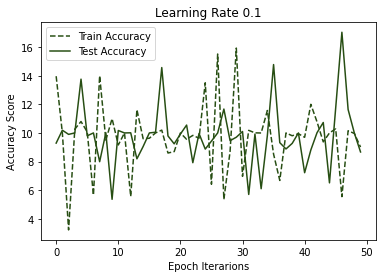

In [7]:
import torch.optim as optim 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

#def dropout_fn():
  #drop_out = [0.3, 0.2, 0.5]

#def lr_fn():
  #learning_rate_ls = [0.001, 0.5, 1, 10]

def weights_init(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(layer.weight)

def evaluation(dataloader):
  #cnn = CNN().to(device)
  #cnn.eval() #for dropout
  torch.no_grad()
  total, correct = 0,0
    
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = cnn(inputs)
    _, predicted = torch.max(outputs.data, 1) 
    total += labels.size(0)
    correct += (predicted== labels).sum().item() 
  return 100 * correct / total 

def train_nn(l_rate =0.1, num_epoch = 50):

  train_loss =0
  test_loss = 0
  loss_array = []
  train_acc=[]
  test_acc = []
  
  cnn = CNN().to(device)
  cnn.apply(weights_init)

  optimizer = optim.SGD(cnn.parameters(), lr=l_rate ) 
  criterion = nn.CrossEntropyLoss()


  for epoch in range(num_epoch):
    epoch_loss =0
    
    cnn.train()
    for i, (images, labels) in enumerate(training_loader, 0):
      images, labels = images.to(device), labels.to(device)
      outputs = cnn(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step() 
      optimizer.zero_grad() 
      epoch_loss += loss.item()

    loss_array.append(epoch_loss)
    train_acc.append(evaluation(training_loader))
    test_acc.append(evaluation(test_loader))
  
    print(f'Epoch {epoch+1}/{num_epoch}\n'+ '-'*10)
    print('train accuracy: %.4f\t test accuracy: %.4f\t loss: %.4f'%(train_acc[-1],test_acc[-1], loss_array[-1]) )
  
  return loss_array, train_acc,test_acc
  
loss, train, test = train_nn()
plot_acc(train, test, "Learning Rate 0.1")

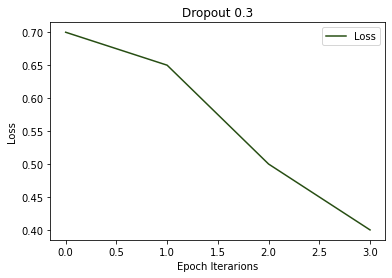

In [3]:
import matplotlib.pyplot as plt

def plot_acc(train, test, plot_title = 'Accuracy Curve' ):
  plt.plot(train, '--', color="#274e13",  label="Train Accuracy")
  plt.plot(test, color="#274e13", label="Test Accuracy")
  plt.title(plot_title), plt.xlabel("Epoch Iterarions"), plt.ylabel('Accuracy Score'), plt.legend(loc="best")

def plot_loss(loss, loss_plot_title = 'Loss Curve'):
  plt.plot(loss, color="#274e13", label="Loss")
  plt.title(loss_plot_title), plt.xlabel("Epoch Iterarions"), plt.ylabel('Loss'), plt.legend(loc="best")

plot_loss([0.7, 0.65,0.5,0.4], 'Dropout 0.3') #test function